# MIIII

In [1]:
from matplotlib import pyplot as plt
from functools import partial
from jax import random
import numpy as np
import darkdetect
import miiiii

In [2]:
# set font to computer modern
plt.rcParams["font.family"] = "serif"

In [3]:
seed = 0
cfg, (rng, key) = miiiii.get_conf(), random.split(random.PRNGKey(seed))
ns = partial(miiiii.base_ns, miiiii.digit_fn)
train_data, valid_data = miiiii.prime_fn(cfg.n, cfg.base, ns, rng)
params = miiiii.init_fn(key, cfg, *train_data)

# train
apply_fn = miiiii.make_apply_fn(miiiii.vaswani_fn)
args = (apply_fn, params, cfg, miiiii.alpha_fn, train_data, valid_data)
train_fn, state = miiiii.init_train(*args)
(params, opt_state, ema_grads), metrics = train_fn(cfg.epochs, rng, state)

In [4]:
train_loss, valid_loss, train_metrics, valid_metrics = metrics

In [5]:
metric_names = {
    "loss": "Focal Loss",
    "acc": "Accuracy",
    "prec": "Precision",
    "rec": "Recall",
    "f1": "F1 Score",
}


def hinton_sub_plot(matrix, cfg, metric, idx, ax=None):
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=300) if ax is None else (fig, ax)
    # metric, split = metric_names[metric.split("_")[1]], metric.split("_")[0]
    bg = "black" if darkdetect.isDark() else "white"
    fg = "white" if darkdetect.isDark() else "black"
    metric = metric_names[metric]
    ax.patch.set_facecolor(bg)
    ax.set_aspect("equal", "box")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    for jdx, ((x, y), w) in enumerate(np.ndenumerate(matrix)):
        s = np.sqrt(w)
        # if idx is last make color red
        c = "#da3527" if (jdx % matrix.shape[1]) == matrix.shape[1] - 1 else fg
        rect = plt.Rectangle([x - s / 2, y - s / 2], s, s, facecolor=c, edgecolor=c)
        ax.add_patch(rect)
    ax.autoscale_view()
    # set ylabel on right side
    ax.set_ylabel(metric, color=fg, rotation=90)
    if idx == 2:
        ax.set_xlabel("Time", color=fg)
    # ax.set_xticks(np.arange(matrix.shape[0], step=cfg.epochs // 20))
    for spine in ax.spines.values():
        spine.set_visible(False)


# plot with 1 col and 4 rows
def hinton_plot(metrics, name):
    fig, axes = plt.subplots(3, 1, figsize=(9, 12), dpi=300)
    bg = "black" if darkdetect.isDark() else "white"
    fg = "white" if darkdetect.isDark() else "black"
    fig.patch.set_facecolor(bg)
    metric_names = ["loss", "f1", "prec", "rec", "acc"]
    # hinton_sub_plot(metric, cfg, met_name, idx, ax=axes[idx])
    axes[0].set_title(name, color=fg)
    for idx, (ax, metric) in enumerate(zip(axes.flatten(), metrics[1:-1])):
        hinton_sub_plot(metric, cfg, metric_names[idx + 1], idx, ax=ax)
    plt.tight_layout()
    # write "Task" on right side (bottom of text should be towards the left (rotated 270))
    fig.text(0.975, 0.5, "Task", ha="center", va="center", rotation=90, color=fg)
    plt.savefig(f"figs/{name}.pdf", bbox_inches="tight", facecolor=bg)

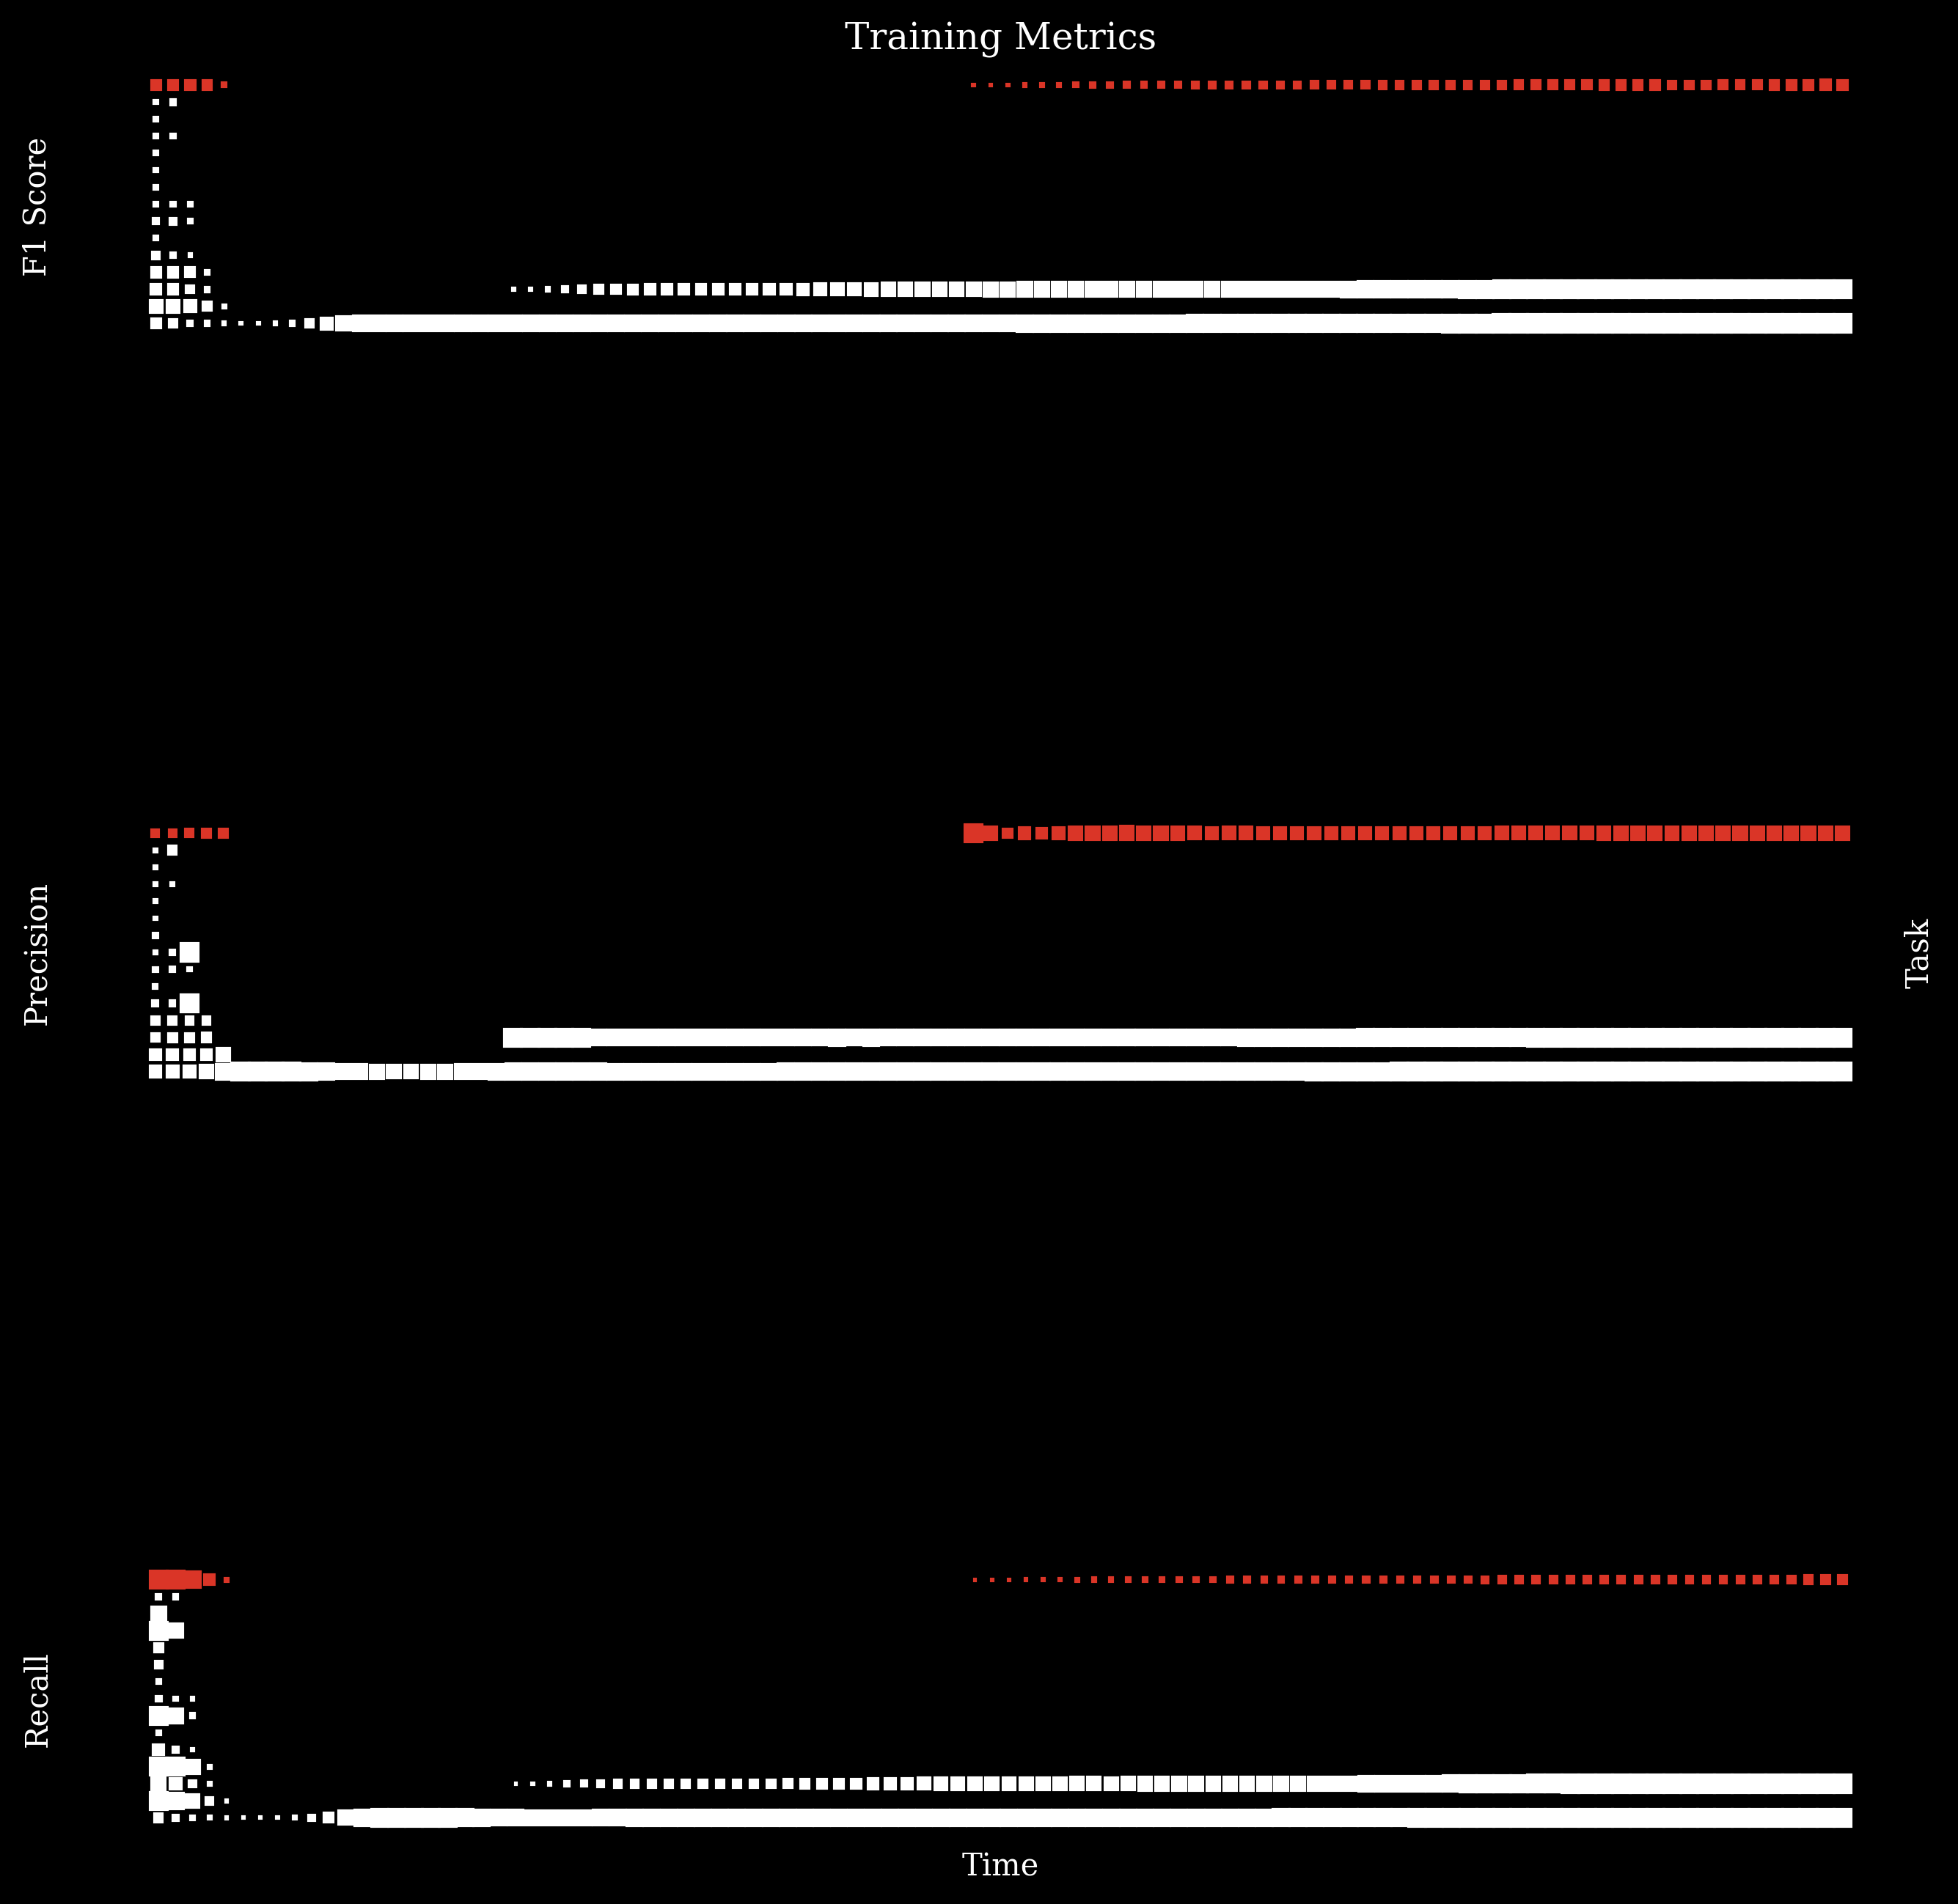

In [6]:
hinton_plot(train_metrics, "Training Metrics")

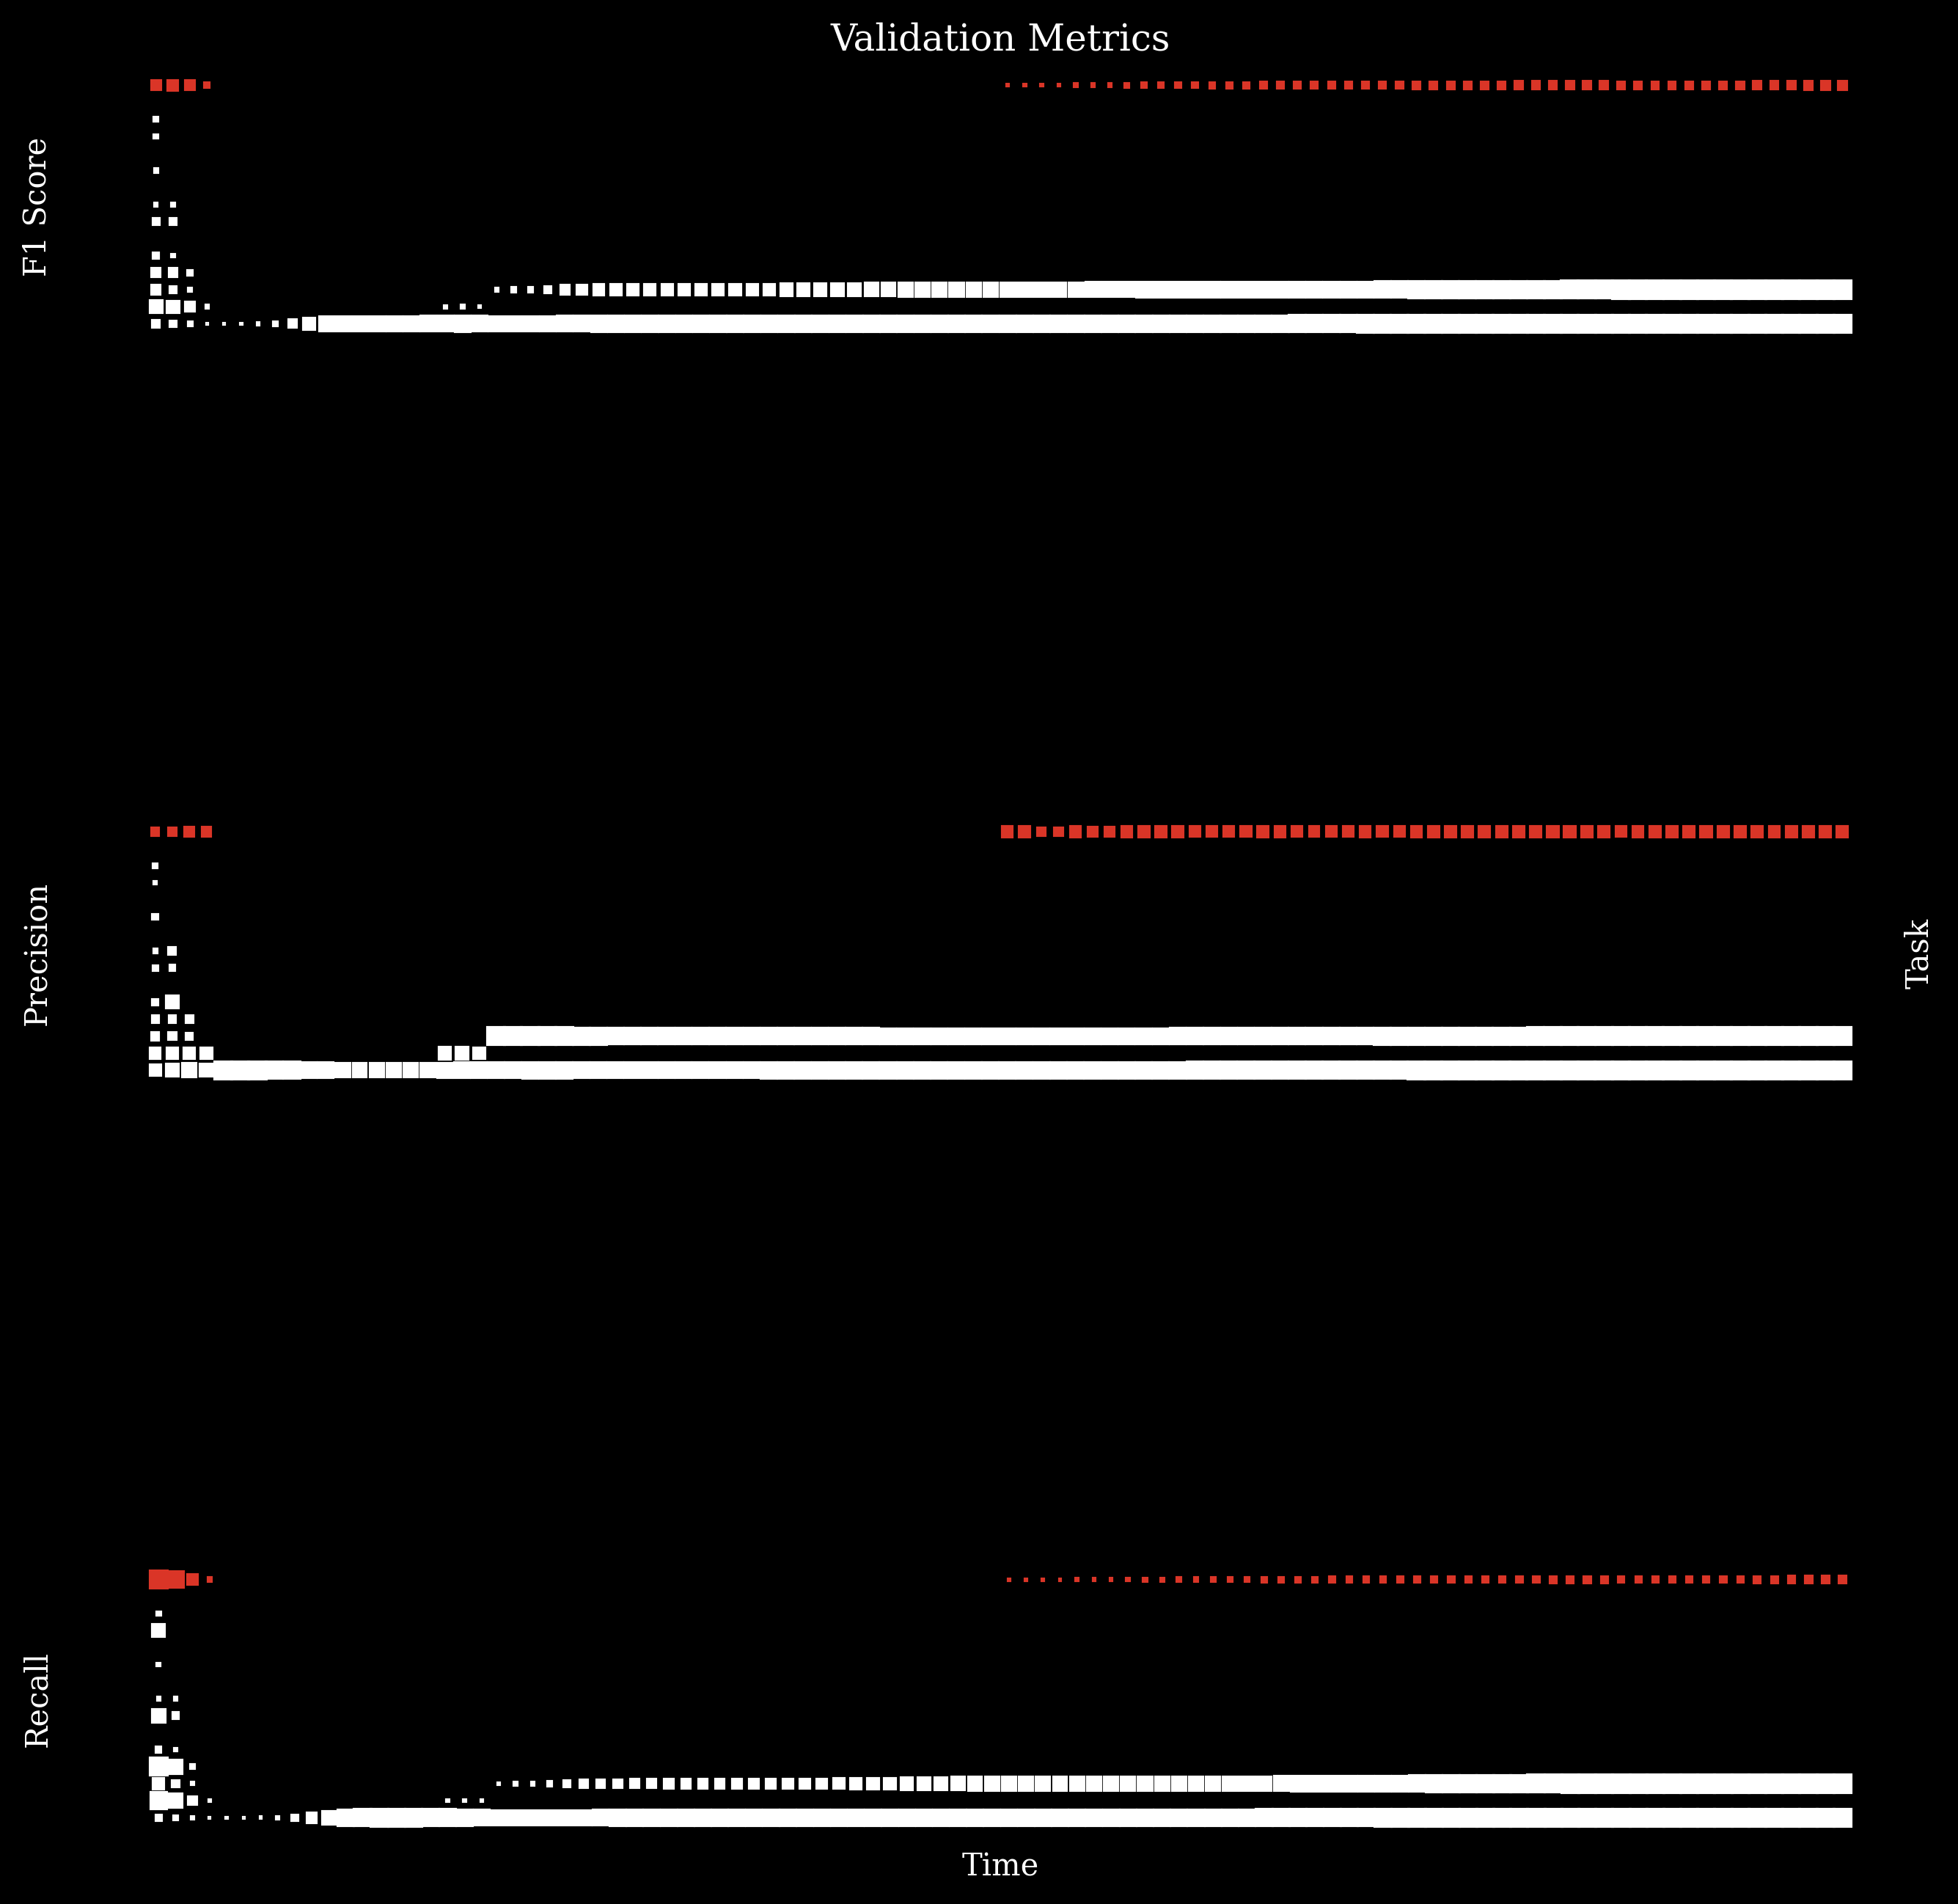

In [7]:
hinton_plot(valid_metrics, "Validation Metrics")